In [1]:
#!/usr/bin/python 

# -*- coding: utf-8 -*-

import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as mp
import matplotlib.pyplot as plt
import time
import seaborn as sns
import random
#from untitled0 import MeanEncoder
 
import tensorflow as tf
import random as rn
 
#random seeds for stochastic parts of neural network 
np.random.seed(10)
from tensorflow import set_random_seed
set_random_seed(15)
 
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\Lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\Lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\Lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\Lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\Lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type,

In [17]:
train = pd.read_csv('F:/dc_xiamen/train.csv')
train_target = pd.read_csv('F:/dc_xiamen/train_target.csv')
train = train.merge(train_target,on='id')
test = pd.read_csv('F:/dc_xiamen/test.csv')

#观测到在5到6.5左右，训练集的lmt出现了测试集中没有的峰值波动，于是考虑到正负样本的比例，在这里扔掉一部分负样本中对应的lmt部分，使lmt分布保持一致
train1 = train.loc[train.target==0]
train2 = train.loc[train.target==1]
a = train1['lmt'].between(5,5.2)
train1 = train1[~a]
a = train1['lmt'].between(6,6.2)
train1 = train1[~a] 

train = pd.concat([train1,train2],axis=0,ignore_index=True)

test['target'] = -999
data = pd.concat([train,test],axis=0,ignore_index=True)

In [6]:
#特征工程
#0. 补全缺失值
data = data.fillna(-999).dropna()

#1.对x相关特征处理,x为征信字段，假设征信字段意义类似，可以利用统计的方法实现部分特征提取
x_feat = ['x_{}'.format(i) for i in range(79)]
    
data['x_count'] = data[x_feat].sum(axis=1)
data['x_var'] = data[x_feat].var(axis=1)

#2.isNew相关  这里假设isnew=0的数据为两个月前的数据（微信群提到），通过组合特征提取相关特征
for i in ['certId']:
    a = data.loc[data.isNew==1]
    b = data.loc[data.isNew==0]
    e = a.groupby([i])['id'].count().reset_index(name='1_count')
    data = data.merge(e,on='certId',how='left')
    
    t = b.groupby([i])['id'].count().reset_index(name='0_count')
    data = data.merge(t,on='certId',how='left')

#3. 构造计数和排序特征
count_fea = ['certId','dist','job','lmt','bankCard','residentAddr','setupHour','weekday','ethnic']
for i in count_fea:
    data[i+'_count'] = data.groupby(i)['id'].transform('count')
    data[i+'_rank'] = data.groupby(i)['id'].transform('rank')

#4， 缺失值统计，统计存在缺失值的特征，构造缺失值相关计数特征
loss_fea = ['bankCard','residentAddr','highestEdu','linkRela']
for i in loss_fea:
    a = data.loc[data[i]==-999]
    e = a.groupby(['certId'])['id'].count().reset_index(name=i+'_certId_count') 
    data = data.merge(e,on='certId',how='left')
    
    d = a.groupby(['loanProduct'])['id'].count().reset_index(name=i+'_loan_count') 
    data = data.merge(d,on='loanProduct',how='left')
    
    m = a.groupby(['job'])['id'].count().reset_index(name=i+'_job_count') 
    data = data.merge(m,on='job',how='left')
    
    data['certloss_'+i] = data[i+'_certId_count']/data['certId_count']
    data['jobloss_'+i] = data[i+'_job_count']/data['job_count']

#5.时间戳处理  将时间段进行转化并处理
data['begintime'] =pd.to_datetime(data['certValidBegin']*1000000000)-pd.offsets.DateOffset(years=70)
data['today'] =pd.to_datetime('2019-10-29')
data['day'] =(data['today'] - data['begintime']).map(lambda x:x.days)
data['time_range'] = data['certValidStop']-data['certValidBegin']    #证件时间段

del data['today']
del data['certValidBegin']
del data['certValidStop']
del data['begintime']
del data['5yearBadloan']
del data['job_rank']

#6.lmt相关 观察线上线下得知lmt是重要特征，于是进行额外处理
for i in ['certId','bankCard']:
#    data['lmt_mean'+i] = data.groupby(i)['lmt'].transform('count')
    data['lmt_nunique'+i] = data.groupby(i)['lmt'].transform('nunique')

#7.bankcard相关 特征预处理得知bankcard，dist，certId，residengAddr在意义上存在强相关性，于是根据实际意义进行处理

data['bankcard_null'] = data['bankCard'].map(lambda x:1 if x==-999  else 0)     #bankcard是否缺失
#data['minority'] = data['ethnic'].map(lambda x:1 if x>0 else 0)     #是否是少数民族
data['distance'] = abs(data['certId']-data['dist'])    #贷款地与原户籍地差
data['distance2'] = abs(data['certId']-data['residentAddr']) 
#data['weekend'] = data['weekday'].map(lambda x:1 if x>5 else 0)  #是否周末

#8. 根据eda扔掉表现不好的特征
del data['unpayIndvLoan']
del data['unpayOtherLoan']
del data['unpayNormalLoan']
del data['setupHour_rank']
del data['residentAddr_job_count']
del data['linkRela_job_count']

x_feat = ['x_{}'.format(i) for i in [66,74,47,63,52,54,51,26,25,73,65,30,12,61,76,44,49,69,35]]
for i in x_feat:
    del data[i]

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.781304	valid_1's auc: 0.69221
[2000]	training's auc: 0.814298	valid_1's auc: 0.702427
[3000]	training's auc: 0.838299	valid_1's auc: 0.706619
[4000]	training's auc: 0.857365	valid_1's auc: 0.706577
[5000]	training's auc: 0.872831	valid_1's auc: 0.707151
[6000]	training's auc: 0.885559	valid_1's auc: 0.705889
[7000]	training's auc: 0.896274	valid_1's auc: 0.703841
Early stopping, best iteration is:
[4798]	training's auc: 0.869987	valid_1's auc: 0.707311
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.778231	valid_1's auc: 0.692301
[2000]	training's auc: 0.810355	valid_1's auc: 0.703283
[3000]	training's auc: 0.835443	valid_1's auc: 0.710649
[4000]	training's auc: 0.853823	valid_1's auc: 0.71444
[5000]	training's auc: 0.869267	valid_1's auc: 0.715246
[6000]	training's auc: 0.882183	valid_1's auc: 0.71527
[7000]	training's auc: 0.893191	valid_1's 

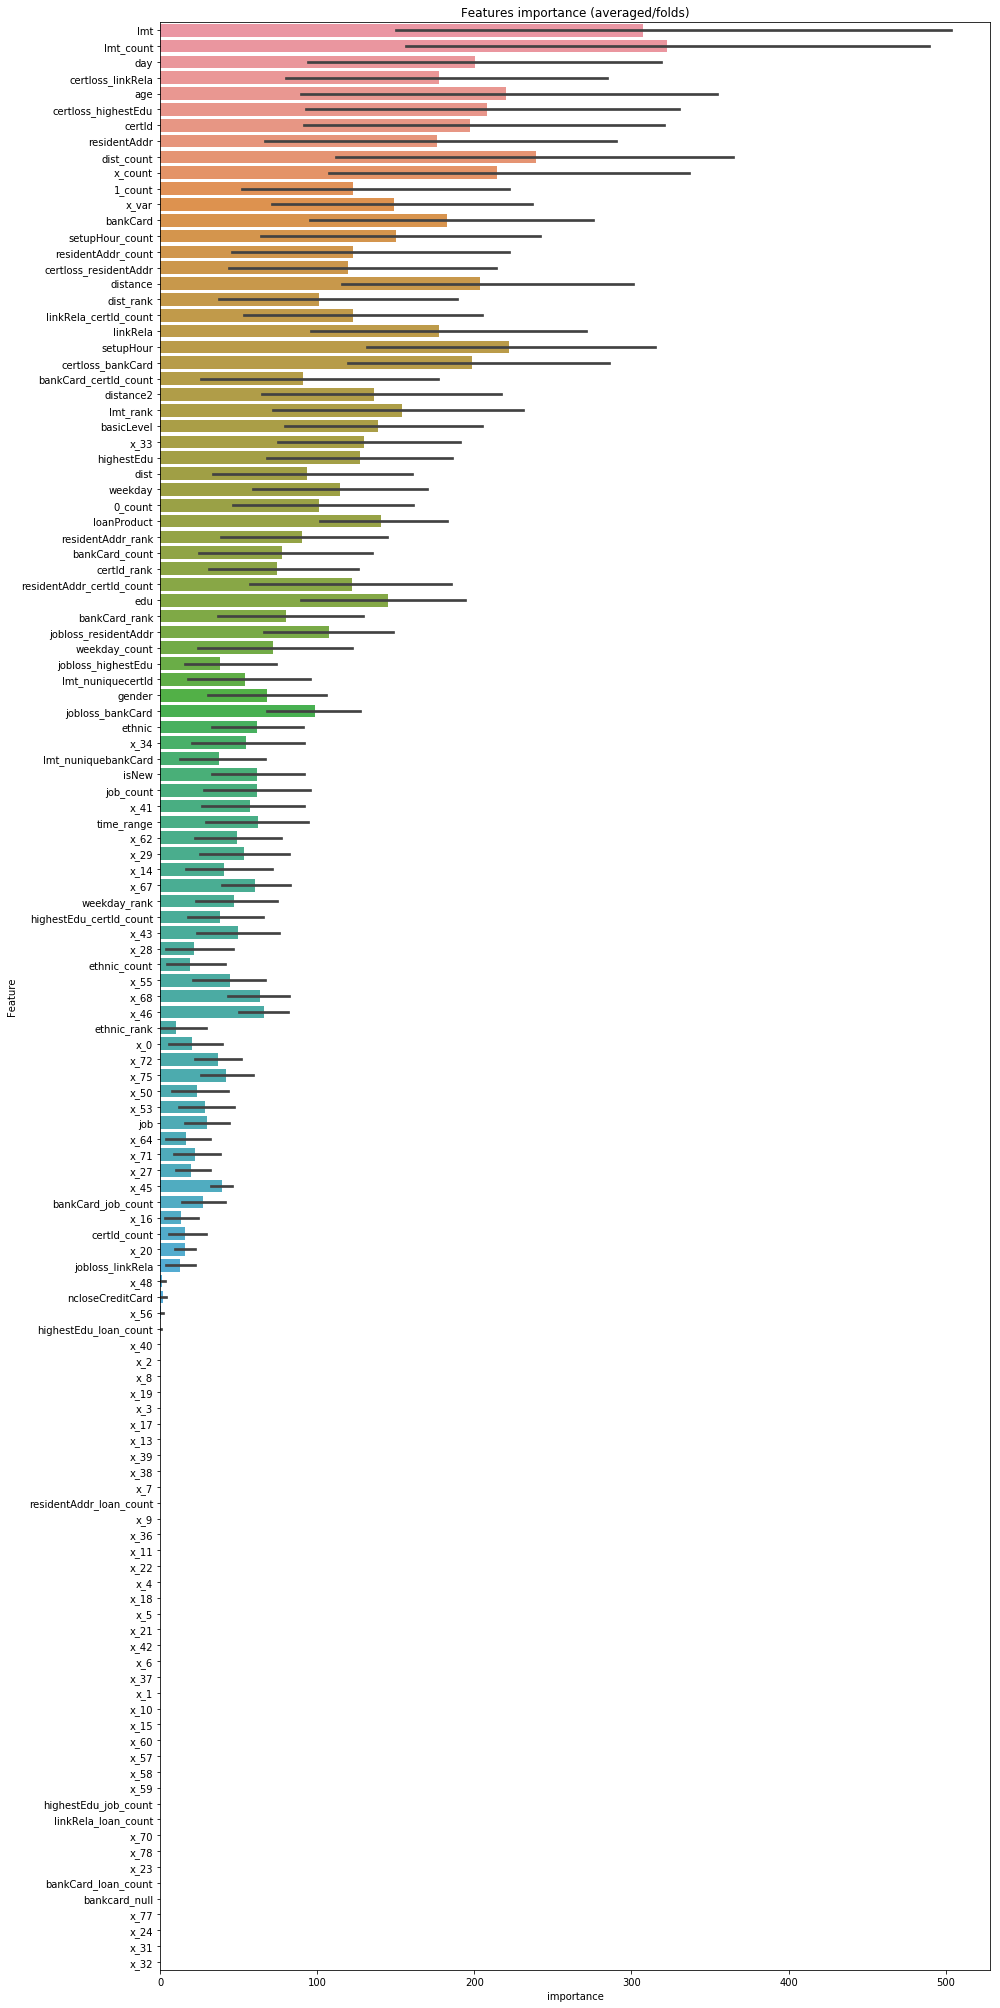

In [7]:
#lgb
train_df = data[data['target']>=0]
test = data[data['target']<0]


features = [c for c in data.columns if c not in ['target','id']]
target = train_df['target']

param = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'num_leaves': 2 ** 5 - 1,
    'min_child_samples':50,
    'max_bin':50,
    'min_child_weight': 0,
    'scale_pos_weight': 15,
    'feature_fraction_seed':2019 ,
    'max_depth':2,
    'nthread': 4,
    'verbose': 0,
    'lambda_l1': 1,
    'lambda_l2': 0
               }
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=2020)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

#画图 
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('F:/26.png')

sub_df = pd.DataFrame({"id":test["id"].values})
sub_df["target"] = predictions.round(6)
sub_df.to_csv("F:/submission27.csv", index=False)

